In [15]:
import sys
import os
sys.path.append(os.path.abspath('../..'))
from vizgen_data_analysis import datareader, datawriter

from starfish import data, Experiment, FieldOfView, Codebook
from starfish.types import Axes, Features

from matplotlib import pyplot as plt
from pprint import pp
from pathlib import Path, PosixPath
import numpy as np
import pandas as pd
from PIL import Image
from hashlib import sha256
import json

from tqdm import tqdm

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [16]:
SOURCE:   PosixPath     =   Path(('/mnt/ibm_lg/merscope/merfish_raw_data/'
                                  '202205191322_MsKidney-wtK3-VZG116b-VT-061922_VMSC02401'))
CODEBOOK: PosixPath     =   list(SOURCE.glob("codebook*.csv"))[0]
DATA_CSV: PosixPath     =   SOURCE/'dataorganization.csv'
DATA_DIR: PosixPath     =   SOURCE/'data'

DIR_OUT:  PosixPath     =   Path('/mnt/ibm_lg/jai.hebel/starfish-data')/SOURCE.stem 
DATA_OUT: PosixPath     =   DIR_OUT/"data"

DATA_OUT.mkdir(parents=True ,exist_ok=True)

In [17]:
MERLIN_ANALYSIS:  PosixPath   =   Path("/mnt/ibm_lg/merscope/merfish_output") / SOURCE.stem
MATRIX_FILE:      PosixPath   =   list(MERLIN_ANALYSIS.glob("**/micron_to_mosaic_pixel_transform.csv"))[0]

MICRON_TO_PIXEL_MATRIX: np.array = np.loadtxt(MATRIX_FILE)

## Codebook Conversion

Converting `codebook.csv` to `codebook.json`

In [18]:
def load_csv_codebook(csv_path):
   """ CSV to JSON codebook
   """
   csv_codebook: pd.DataFrame = pd.read_csv(csv_path, index_col=0)
   csv_codebook = csv_codebook.drop(columns=["id"]) # Drop ID column

   N_CHANNELS = 3 # Assuming 3 channels
   RC_MAP = { # Each bitcode name corresponds to a (round, channel) combination
   csv_codebook.columns[i]: (i//N_CHANNELS, i%N_CHANNELS) 
   for i in range(csv_codebook.shape[1])
   }

   def parse_codewords(row):
      row = row[row == 1]
      codewords = [
         {
            Axes.ROUND.value:       r,
            Axes.CH.value:          c,
            Features.CODE_VALUE:    1
         } for (r,c) in (RC_MAP[marker] for marker in row.index)
      ]
      return {
         Features.CODEWORD:      codewords,
         Features.TARGET:        row.name
      }
      

   mappings = csv_codebook.apply(parse_codewords, axis=1).to_list()
   return Codebook.from_code_array(mappings)

In [19]:
codebook = load_csv_codebook(CODEBOOK)
codebook.to_json(DIR_OUT/'codebook.json')
codebook

<xarray.Codebook (target: 315, r: 8, c: 3)>
array([[[0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
...
        ...,
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        ...,
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 0]],

       [[0, 0, 1],
        [0, 0, 0],
        [1, 0, 0],
        ...,
        [0, 1, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'Sox17' 'Zap70' 'Slc40a1' ... 'Blank-17' 'Blank-18'
  * r        (r) int64 0 1 2 3 4 5 6 7
  * c        (c) int64 0 1 2

In [20]:
codebook.to_json('/home/jai.hebel/test_codebook.json')

## Load data organization file

In [21]:
def load_data_organization(csv_path):
  df = pd.read_csv(csv_path)
  df.zPos, df.frame =  (df.zPos.apply(lambda x: x[1:-1].split(',')),
                        df.frame.apply(lambda x: x[1:-1].split(',')))
  return df
  

In [22]:
data_organization = load_data_organization(DATA_CSV)
display(data_organization)

,channelName,readoutName,imageType,imagingRound,imageRegExp,bitNumber,color,frame,zPos,fiducialImageType,fiducialRegExp,fiducialImagingRound,fiducialFrame,fiducialColor
0,bit1,V0001T8B1,stack,0,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,1.0,560,"[15, 16, 17, 18, 19, 20, 21]","[1.5, 3, 4.5, 6, 7.5, 9, 10.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,0,0,488
1,bit2,V0002T8B1,stack,0,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,2.0,650,"[8, 9, 10, 11, 12, 13, 14]","[10.5, 9, 7.5, 6, 4.5, 3, 1.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,0,0,488
2,bit3,V0003T8B1,stack,0,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,3.0,750,"[1, 2, 3, 4, 5, 6, 7]","[1.5, 3, 4.5, 6, 7.5, 9, 10.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,0,0,488
3,bit4,V0004T8B1,stack,1,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,4.0,560,"[15, 16, 17, 18, 19, 20, 21]","[1.5, 3, 4.5, 6, 7.5, 9, 10.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,1,0,488
4,bit5,V0005T8B1,stack,1,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,5.0,650,"[8, 9, 10, 11, 12, 13, 14]","[10.5, 9, 7.5, 6, 4.5, 3, 1.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,1,0,488
5,bit6,V0006T8B1,stack,1,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,6.0,750,"[1, 2, 3, 4, 5, 6, 7]","[1.5, 3, 4.5, 6, 7.5, 9, 10.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,1,0,488
6,bit7,V0007T8B1,stack,2,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,7.0,560,"[15, 16, 17, 18, 19, 20, 21]","[1.5, 3, 4.5, 6, 7.5, 9, 10.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,2,0,488
7,bit8,V0008T8B1,stack,2,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,8.0,650,"[8, 9, 10, 11, 12, 13, 14]","[10.5, 9, 7.5, 6, 4.5, 3, 1.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,2,0,488
8,bit9,V0009T8B1,stack,2,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,9.0,750,"[1, 2, 3, 4, 5, 6, 7]","[1.5, 3, 4.5, 6, 7.5, 9, 10.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,2,0,488
9,bit10,V0010T8B1,stack,3,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,10.0,560,"[15, 16, 17, 18, 19, 20, 21]","[1.5, 3, 4.5, 6, 7.5, 9, 10.5]",stack,(?P<imageType>[\w|-]+)_(?P<imagingRound>[0-9]+...,3,0,488


## Data

In [23]:
inf_files = [f for f in sorted(DATA_DIR.glob('*.inf'))]
dax_files = [f for f in sorted(DATA_DIR.glob('*.dax'))] 

In [24]:
def read_inf(inf_file):
  with open(inf_file) as f:
    lines = f.readlines()
    return dict(line.rstrip().split(" = ") for line in lines)

In [25]:
read_inf(inf_files[0])

{'binning': '1 x 1',
 'data type': '16 bit integers (binary, little endian)',
 'frame dimensions': '2048 x 2048',
 'number of frames': '22',
 'x_start': '1',
 'x_end': '2048',
 'y_start': '1',
 'y_end': '2048',
 'position': '(4200.0, -800.0, 2100.63)'}

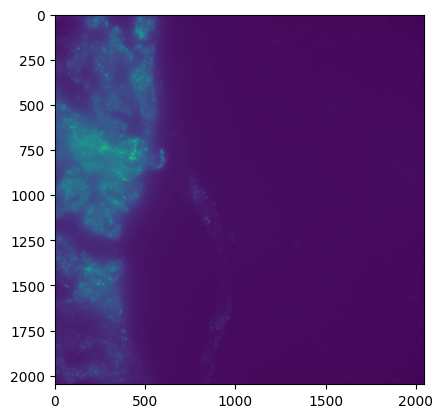

In [26]:
dax = datareader.DaxReader(dax_files[0])
plt.imshow(dax.loadAFrame(1))


In [27]:
def index_data_dir(dir, csv):
  inf_files = [f for f in sorted(dir.glob('*.inf'))]
  dax_files = [f for f in sorted(dir.glob('*.dax'))] 

  file_names = [f.stem for f in dax_files]
  df = pd.DataFrame({'image': file_names, 'dax': dax_files, 'inf': inf_files})
  df[['image_type', 'round', 'fov']] = df.image.str.split("_", expand=True)
  df = pd.concat([df, pd.DataFrame(df.inf.apply(read_inf).tolist())], axis=1)
  
  df["image_type"] = "primary"
  df['image_type'][df['round']=="prestain"] = "nucleic"
  df['round'][df['round']=="prestain"] = "-1"
  df['round'] = df['round'].astype("int")
  
  data_organization = load_data_organization(csv)
  data_organization = data_organization.apply(lambda x: x.explode() if x.name in ["frame", "zPos"] else x).reset_index(drop=True)
  df = pd.merge(df, data_organization, left_on="round", right_on="imagingRound", how="left")

  wavelengths = df.color.unique()
  channels = list(range(len(wavelengths)))
  map_wavelengths_to_channels = {wl: ch for (wl,ch) in zip(wavelengths, channels)}
  
  def index_map(values):
    """ Create a dict/map that converts a list of values to a list of int indices
        This can be created for an entire column, then applied to each row
        ex. [560, 650, 750] -> [0, 1, 2]
    """
    unique_values = values.unique().astype(float)
    indices = list(range(len(unique_values)))
    return {v: i for (v, i) in zip(unique_values, indices)}
  
  color_map = index_map(df.color)
  zPos_map = index_map(df.zPos)
  
  start_pixels = df[['x_start', 'y_start', 'zPos']].astype(float).to_numpy()
  df['start_coordinates'] = [row for row in (np.linalg.inv(MICRON_TO_PIXEL_MATRIX) @ start_pixels.T).T]
  end_pixels = df[['x_end', 'y_end', 'zPos']].astype(float).to_numpy()
  df['end_coordinates'] = [row for row in (np.linalg.inv(MICRON_TO_PIXEL_MATRIX) @ end_pixels.T).T]
  
  df['xc'] = df.apply(lambda x: [x.start_coordinates[0], x.end_coordinates[0]], axis=1)
  df['yc'] = df.apply(lambda x: [x.start_coordinates[1], x.end_coordinates[1]], axis=1)
  df['zc'] = df.apply(lambda x: [x.start_coordinates[2], x.end_coordinates[2]], axis=1)
  
  df['r'] = df['round']
  df['c'] = df.color.apply(lambda x: color_map[x])
  df['z'] = df.zPos.apply(lambda x: zPos_map[float(x)])
  df['tiff'] = "primary-images-fov_" + df.fov.astype(str) + "-c" + df.c.astype(str) + "-r" + df.r.astype(str) + "-z" + df.z.astype(str) + ".tiff"

  return df

In [36]:
x.columns

Index(['image', 'dax', 'inf', 'image_type', 'round', 'fov', 'binning',
       'data type', 'frame dimensions', 'number of frames', 'x_start', 'x_end',
       'y_start', 'y_end', 'position', 'channelName', 'readoutName',
       'imageType', 'imagingRound', 'imageRegExp', 'bitNumber', 'color',
       'frame', 'zPos', 'fiducialImageType', 'fiducialRegExp',
       'fiducialImagingRound', 'fiducialFrame', 'fiducialColor',
       'start_coordinates', 'end_coordinates', 'xc', 'yc', 'zc', 'r', 'c', 'z',
       'tiff'],
      dtype='object')

In [28]:
image_data = index_data_dir(DATA_DIR, DATA_CSV)
image_data

# %lprun -f index_data_dir index_data_dir(DATA_DIR, DATA_CSV)

,image,dax,inf,image_type,round,fov,binning,data type,frame dimensions,number of frames,...,fiducialColor,start_coordinates,end_coordinates,xc,yc,zc,r,c,z,tiff
0,stack_0_000,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,primary,0,000,1 x 1,"16 bit integers (binary, little endian)",2048 x 2048,22,...,488,"[19.938418121865396, 7.898577961529601, 1.5]","[241.01173212292935, 228.9701614885875, 1.5]","[19.938418121865396, 241.01173212292935]","[7.898577961529601, 228.9701614885875]","[1.5, 1.5]",0,0,0,primary-images-fov_000-c0-r0-z0.tiff
1,stack_0_000,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,primary,0,000,1 x 1,"16 bit integers (binary, little endian)",2048 x 2048,22,...,488,"[39.768837555894414, 15.689158080593614, 3.0]","[260.84215155695836, 236.76074160765154, 3.0]","[39.768837555894414, 260.84215155695836]","[15.689158080593614, 236.76074160765154]","[3.0, 3.0]",0,0,1,primary-images-fov_000-c0-r0-z1.tiff
2,stack_0_000,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,primary,0,000,1 x 1,"16 bit integers (binary, little endian)",2048 x 2048,22,...,488,"[59.59925698992343, 23.47973819965763, 4.5]","[280.67257099098737, 244.55132172671554, 4.5]","[59.59925698992343, 280.67257099098737]","[23.47973819965763, 244.55132172671554]","[4.5, 4.5]",0,0,2,primary-images-fov_000-c0-r0-z2.tiff
3,stack_0_000,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,primary,0,000,1 x 1,"16 bit integers (binary, little endian)",2048 x 2048,22,...,488,"[79.42967642395246, 31.27031831872164, 6.0]","[300.50299042501643, 252.34190184577955, 6.0]","[79.42967642395246, 300.50299042501643]","[31.27031831872164, 252.34190184577955]","[6.0, 6.0]",0,0,3,primary-images-fov_000-c0-r0-z3.tiff
4,stack_0_000,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,primary,0,000,1 x 1,"16 bit integers (binary, little endian)",2048 x 2048,22,...,488,"[99.26009585798147, 39.06089843778565, 7.5]","[320.33340985904545, 260.1324819648436, 7.5]","[99.26009585798147, 320.33340985904545]","[39.06089843778565, 260.1324819648436]","[7.5, 7.5]",0,0,4,primary-images-fov_000-c0-r0-z4.tiff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174715,stack_prestain_959,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,nucleic,-1,959,1 x 1,"16 bit integers (binary, little endian)",2048 x 2048,15,...,488,"[99.26009585798147, 39.06089843778565, 7.5]","[320.33340985904545, 260.1324819648436, 7.5]","[99.26009585798147, 320.33340985904545]","[39.06089843778565, 260.1324819648436]","[7.5, 7.5]",-1,4,4,primary-images-fov_959-c4-r-1-z4.tiff
174716,stack_prestain_959,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,nucleic,-1,959,1 x 1,"16 bit integers (binary, little endian)",2048 x 2048,15,...,488,"[79.42967642395246, 31.27031831872164, 6.0]","[300.50299042501643, 252.34190184577955, 6.0]","[79.42967642395246, 300.50299042501643]","[31.27031831872164, 252.34190184577955]","[6.0, 6.0]",-1,4,3,primary-images-fov_959-c4-r-1-z3.tiff
174717,stack_prestain_959,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,nucleic,-1,959,1 x 1,"16 bit integers (binary, little endian)",2048 x 2048,15,...,488,"[59.59925698992343, 23.47973819965763, 4.5]","[280.67257099098737, 244.55132172671554, 4.5]","[59.59925698992343, 280.67257099098737]","[23.47973819965763, 244.55132172671554]","[4.5, 4.5]",-1,4,2,primary-images-fov_959-c4-r-1-z2.tiff
174718,stack_prestain_959,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,/mnt/ibm_lg/merscope/merfish_raw_data/20220519...,nucleic,-1,959,1 x 1,"16 bit integers (binary, little endian)",2048 x 2048,15,...,488,"[39.768837555894414, 15.689158

## Data Conversion

In [29]:
def create_tile_record(tile):
  x_shape, y_shape = tile['frame dimensions'].split(" x ") 
  
  return {
    "coordinates": {
        "xc": tile.xc,
        "yc": tile.yc,
        "zc": tile.zc
    },
    "file": str((DATA_OUT/f"fov_{tile.fov}/{tile['tiff']}").relative_to(DIR_OUT)),
    "indices": {
        "c": tile.c,
        "r": tile.r,
        "z": tile.z
    },
    "sha256": tile.sha256,
    "tile_format": "TIFF",
    "tile_shape": {
        "x": x_shape,
        "y": y_shape
    }
  }

In [30]:
def create_fov_record(tile_stack, c_size, r_size, z_size):
  return {
    "default_tile_format": "TIFF",
    "dimensions": [
        "z",
        "xc",
        "x",
        "yc",
        "y",
        "zc",
        "c",
        "r"
    ],
    "extras": {},
    "shape": {
        "c": c_size,
        "r": r_size,
        "z": z_size
    },
    "tiles": tile_stack,
    "version": "0.1.0"
  }

In [31]:
def create_manifest_record(fov_directory):
  return {
  "version": "0.0.0",
  "contents": fov_directory,
  "extras": "null"
}

In [32]:
def create_experiment_record(manifest_directory):
  return {
  "version": "0.0.0",
  "images": manifest_directory,
  "codebook": "codebook.json",
  "extras": {
    "is_space_tx_cool": True
  }
}

In [33]:
def split_dax_frames_into_tiff_files(x, dax_reader):
    target_dir = DATA_OUT / f"fov_{x.fov}"
    target_dir.mkdir(parents=True, exist_ok=True)
    data = dax_reader.loadAFrame(int(x.frame))
    tiff_file = datawriter.TiffWriter(target_dir/x.tiff)
    tiff_file.addFrame(data)
    tiff_file.close()

In [34]:
primary_image_data = image_data[image_data['round'] != -1]

fov_directory = {}
manifest_directory = {}

c_size, r_size, z_size = (
    len(primary_image_data.c.unique()),
    len(primary_image_data.r.unique()),
    len(primary_image_data.z.unique())
  )

for fov, group in tqdm(primary_image_data.groupby("fov"), desc="Converting fovs"):
  
  for dax_file, subgroup in group.groupby("dax"):
    dax_reader = datareader.DaxReader(dax_file)
    group.loc[group.dax==dax_file, 'sha256'] = dax_reader.hashID()
    subgroup.apply(split_dax_frames_into_tiff_files, dax_reader=dax_reader, axis=1)
    
  tile_stack = group.apply(create_tile_record, axis=1).tolist()
  fov_record = create_fov_record(tile_stack, c_size, r_size, z_size)
  
  fov_path = DATA_OUT/f"fov_{fov}/primary-images-fov_{fov}.json"
  fov_directory[f"fov_{fov}"] = str(fov_path.relative_to(DIR_OUT))
  with open(fov_path, "w") as fov_file:
    json.dump(fov_record, fov_file)

manifest_record = create_manifest_record(fov_directory)
manifest_path = "primary_images.json"
manifest_directory['primary'] = manifest_path
with open(DIR_OUT/manifest_path, "w") as manifest_file:
  json.dump(manifest_record, manifest_file)

experiment_record = create_experiment_record(manifest_directory)
with open(DIR_OUT/'experiment.json', "w") as experiment_file:
  json.dump(experiment_record, experiment_file)
  
# TODO: repeat for other image types

Converting fovs:   0%|          | 1/960 [00:25<6:49:33, 25.62s/it]


KeyboardInterrupt: 

In [ ]:
fov_record